# Capstone 2.3: Predicted Circular Dichroism Spectra from Primary Amino Acid Sequence

## Exploratory Data Analysis (EDA)

Data is coming from the Protein Circular Dichroism Data Bank (https://pcddb.cryst.bbk.ac.uk/).
Citation information: The PCDDB (protein circular dichroism data bank): A bioinformatics resource for protein characterisations and methods development. Ramalli SG, Miles AJ, Janes RW, Wallace BA., J Mol Biol (2022) 

In [1]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import traceback
from aaindex import aaindex1

from sklearn.model_selection import train_test_split

In [2]:
# Unpickle data
# dfOG = pd.read_pickle('pcd_df.pkl')
dfOG = pd.read_pickle("C:/Users/dkoul/OneDrive/Documents/Springboard/Capstone 2/pcd_df.pkl")

## Data Structure Reminder

The dataframe contains the PCDDB IDs as the index values, with three corresponding columns for each.

In [3]:
dfOG.head()

,Info,CD,Calibration
CD0000001000,"{'PCDDBID': 'CD0000001000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed...,Wavelength Calibration Spectrum 0 ...
CD0000002000,"{'PCDDBID': 'CD0000002000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed ...,Wavelength Calibration Spectrum 0 ...
CD0000003000,"{'PCDDBID': 'CD0000003000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed Av...,Wavelength Calibration Spectrum 0 ...
CD0000004000,"{'PCDDBID': 'CD0000004000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed Av...,Wavelength Calibration Spectrum 0 ...
CD0000005000,"{'PCDDBID': 'CD0000005000', 'FILE EXTRACTED': ...",Wavelength Final HT Smoothed...,Wavelength Calibration Spectrum 0 ...


In [4]:
print(type(dfOG['Info']))
print(type(dfOG['Info'][0]))
print(dfOG['Info'][0].keys())

<class 'pandas.core.series.Series'>
<class 'dict'>
dict_keys(['PCDDBID', 'FILE EXTRACTED', 'Protein Name', 'Alternative Protein Names', 'Source Organism', 'Protein Supplier', 'Expression System or natural source', 'Expressed As', 'Mutation Details', 'Expression tags (if any)', 'Ligands Present and Concentration or ratio', 'Macromolecular Partner(s) and Concentration or ratio', 'Deposition Date', 'Dichroism Units of Raw Sample Data', 'Dichroism Units of Raw Baseline Data', 'Dichroism Units of Average Sample Data', 'Dichroism Units of Averaged Baseline Data', 'Dichroism Units of Net Smoothed Data', 'Dichroism Units of Processed Data', 'CD or SRCD', 'Protein Concentration (mg/ml)', 'Concentration Quantification Method', 'Protein Purity (%)', 'Purity Quantification Method', 'Buffer Contents and Concentrations', 'Baseline Contents', 'Experimental Temperature (C)', 'Instrument or beamline', 'Detector Angle (Scattering Angle)', 'Sample Cell Pathlength (cm)', 'Cell Pathlength Calibration Metho

C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\1884154440.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(dfOG['Info'][0]))
C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\1884154440.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dfOG['Info'][0].keys())


Info column is a pandas series of dictionaries of the metadata for each entry with the keys indicated above.

In [5]:
print(type(dfOG['CD']))
print(type(dfOG['CD'][0]))
print(dfOG['CD'][0].head())

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
   Wavelength     Final        HT  Smoothed  Avg. Sample  Avg.Baseline
0       300.0 -0.018660  237727.0  -129.733     465689.0      465406.0
1       299.0 -0.109954  237082.0  -765.400     465460.0      465812.0
2       298.0 -0.004505  236498.0   -31.400     465667.0      465285.0
3       297.0  0.044540  235893.0   310.822     466046.0      465040.0
4       296.0  0.059347  235366.0   414.663     465563.0      464877.0


C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\1836454426.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(dfOG['CD'][0]))
C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\1836454426.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dfOG['CD'][0].head())


In [6]:
print(type(dfOG['Calibration']))
print(type(dfOG['Calibration'][0]))
print(dfOG['Calibration'][0].head())

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
  Wavelength  Calibration Spectrum
0      350.0                -602.0
1      349.0                 384.0
2      348.0                -954.0
3      347.0                 641.0
4      346.0                 146.0


C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\3641678982.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(dfOG['Calibration'][0]))
C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\3641678982.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dfOG['Calibration'][0].head())


## Pertinent columns

To develop the algorithm, we will need to identify with of the CD columns to use as our spectrum. We want our algorithm to predict one of the columns vs. the Wavelength. For the input, we will need to access the amino acid sequence. This can be found in the Info dictionary for each entry using the key 'Sequence'. <br>
Other values that are likely to be relevant are the units; of potential utility if data needs to be subsetted further or to enrich predictions might be buffer/temperature/other experimental conditions and potential quality metrics (e.g. 'CD signal at 290nm (mdeg)').

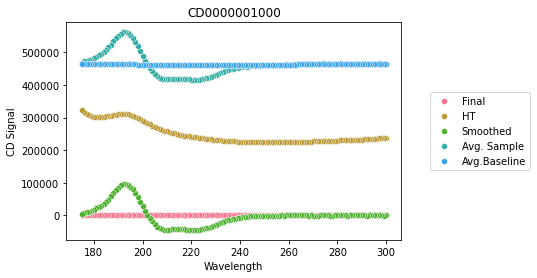

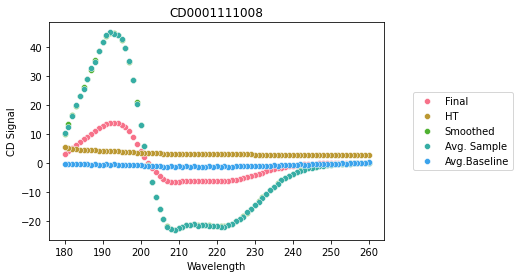

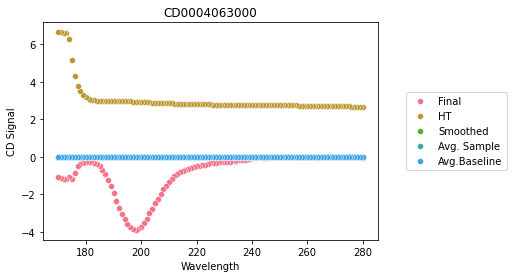

In [7]:
# Plot all six spectra for a few of ids

idx = dfOG.index[0], dfOG.index[200], dfOG.index[500]
spctypes = ['Final', 'HT', 'Smoothed', 'Avg. Sample', 'Avg.Baseline']

for i in idx:
    sns.set_palette('husl')
    data = dfOG.loc[i, 'CD']
    for t in spctypes:
        sns.scatterplot(x = data['Wavelength'], y = data[t])
    plt.ylabel('CD Signal')
    plt.legend(spctypes, loc = 'center right', bbox_to_anchor = (1.4,.5))
    plt.title(i)
    plt.show()

Not totally sure if the plots overlay or just if not all the spectra are available for all the IDs. Let's try the Smoothed and Final spectra and see how they compare, since these are likely to be the most processed/normalized/comparable.

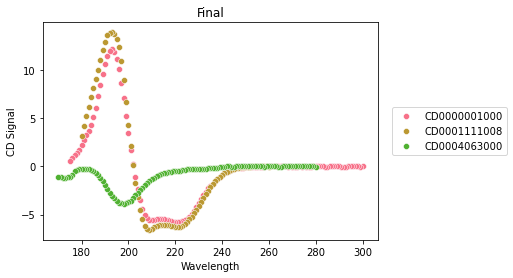

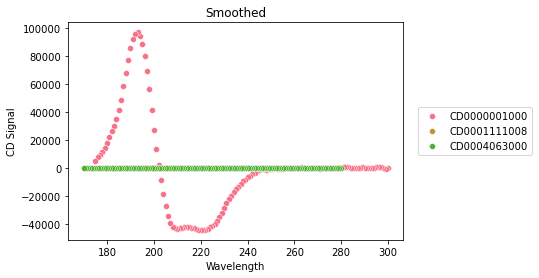

In [8]:
spctypes_analysis = ['Final', 'Smoothed']

for spectrum in spctypes_analysis:
    sns.set_palette('husl')
    for i in idx: 
        data = dfOG.loc[i, 'CD']
        sns.scatterplot(x = data['Wavelength'], y = data[spectrum])
    plt.ylabel('CD Signal')
    plt.legend(idx, loc = 'center right', bbox_to_anchor = (1.4,.5))
    plt.title(spectrum)
    plt.show()

It looks like we see more features in the "Final" spectra, while smoothed versions are either not available or basically a flat line for some of entries (although potentially could see more features if we zoom in). The y-axis units of the final suggest that it has likely been converted to mean residue ellipticity (mre), but let's confirm.

In [9]:
metadata_fields = dfOG.loc['CD0000001000', 'Info'].keys()
unit_fields = [f for f in metadata_fields if "units" in str.lower(f)]
print(unit_fields)

['Dichroism Units of Raw Sample Data', 'Dichroism Units of Raw Baseline Data', 'Dichroism Units of Average Sample Data', 'Dichroism Units of Averaged Baseline Data', 'Dichroism Units of Net Smoothed Data', 'Dichroism Units of Processed Data', 'Dichroism Units for CSA Standard']


In [10]:
# loop through dataframe to pull out unique values for each of the unit types
# presumably the "processed data" is the final
units_dict = {}
for field in unit_fields:
    units_dict[field] = set()

#entry = dfOG.Info[0]

for i in range(len(dfOG.Info)):
    print(i)
    try:
        entry = dfOG.Info[i]
        for field in unit_fields:
            units_dict[field].add(entry[field])
    except Exception: 
        traceback.print_exc()
        break
print(units_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
{'Dichroism Units of Raw Sample Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Millidegrees (theta)'}, 'Dichroism Units of Raw Baseline Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Millidegrees (theta)'}, 'Dichroism Units of Average Sample Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Millidegrees (theta)'}, 'Dichroism Units of Averaged Baseline Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Millidegrees (theta)'}, 'Dichroism Units of Net Smoothed Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Millidegrees (theta)'}, 'Dichroism Units of Processed Data': {'Delta Epsilon'}, 'Dichroism Units for CSA Standard': {'Mean Residue Ellipticity', 'Millidegrees (theta)', 'DRS units'}}


C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\4101844962.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry = dfOG.Info[i]
Traceback (most recent call last):
  File "C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\4101844962.py", line 14, in <module>
    units_dict[field].add(entry[field])
                          ~~~~~^^^^^^^
KeyError: 'Dichroism Units of Raw Sample Data'


In [11]:
dfOG.Info[72].keys()

C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\3659933405.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfOG.Info[72].keys()


dict_keys(['PCDDBID', 'FILE EXTRACTED', 'Protein Name', 'Alternative Protein Names', 'Source Organism', 'Protein Supplier', 'Zurich', 'E. coli', 'Wild-type', 'No data provided', '2011-08-24', 'Millidegrees (theta)', 'Delta Epsilon', 'SRCD', '6.26', 'Nanodrop', '10mM KH2PO4 pH 7.0; 0.05% CHM', '20', 'Daresbury 12.1', '0.0015', 'Interferometry', 'Cylindrical-Demountable', 'Suprasil', 'Nitrogen', '3', 'Stepped', '280', '173', 'HT value', '1', '2006-09-02', 'r18709', 'CSA', 'YES', '6.57', '0.10', '235-245', '1.97', '26.3', '25', '113573.6', '1049', '108.4', 'CDTool', '1.4', '7', '263-270', 'Crystal structure', '0.486', '0.021', '0.000', '0.186', '0.004', '0.086', '0.065', '0.151', '2gif', 'P31224', '-', '21505036', '1.20.1640.10 3.30.70.1430 3.30.70.1320 3.30.2090.10 1.10.3850.10', 'MPNFFIDRPI FAWVIAIIIM LAGGLAILKL PVAQYPTIAP PAVTISASYP GADAKTVQDT VTQVIEQNMN GIDNLMYMSS NSDSTGTVQI TLTFESGTDA DIAQVQVQNK LQLAMPLLPQ EVQQQGVSVE KSSSSFLMVV GVINTDGTMT QEDISDYVAA NMKDAISRTS GVGDVQLFGS QYAMRIWMNP N

This entry's info dictionary is totally messed up - the keys are not the right keys, many containing values instead of keys. (For example, the sequence right smack in the middle....) Let's see how much entries throw this type of error.

In [12]:
units_dict = {}

for field in unit_fields:
    units_dict[field] = set()

need_tlc = []

for i in range(len(dfOG.Info)):
    try:
        entry = dfOG.Info[i]
        for field in unit_fields:
            units_dict[field].add(entry[field])
    except: need_tlc.append(i)
        
print(units_dict)

{'Dichroism Units of Raw Sample Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Mean Residue Ellipticity', 'Millidegrees (theta)', 'No data provided', 'DRS units'}, 'Dichroism Units of Raw Baseline Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Mean Residue Ellipticity', 'Millidegrees (theta)', 'No data provided', 'DRS units', 'Delta Epsilon'}, 'Dichroism Units of Average Sample Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Millidegrees (theta)', 'No data provided', 'DRS units', 'Delta Epsilon'}, 'Dichroism Units of Averaged Baseline Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Mean Residue Ellipticity', 'Millidegrees (theta)', 'No data provided', 'DRS units'}, 'Dichroism Units of Net Smoothed Data': {'Daresbury Arbitrary Units', 'Millidegrees', 'Mean Residue Ellipticity', 'Millidegrees (theta)', 'No data provided', 'DRS units', 'Delta Epsilon'}, 'Dichroism Units of Processed Data': {'Mean Residue Ellipticity', 'Delta Epsilon'}, 'Dichroism Units for CSA St

C:\Users\dkoul\AppData\Local\Temp\ipykernel_63296\1839587112.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry = dfOG.Info[i]


In [13]:
need_tlc

[72, 74, 98, 121, 482, 508]

Relevant points learned from above: 
1. Entries with indices 72, 74, 98, 121, 482, and 508 seem to have issues in their Info blocks.
2. Units are all over the place, but processed data is the way to go. Here we have two options, so will need to figure out a way to address it.

   $\Delta$ $\epsilon$ = mre / 3298
   (Both $\Delta$ $\epsilon$ (Molar Circular Dichroism) and mre (Mean Residue Ellipticity) have been normalized for protein concentration, protein   size, and pathlength.)

## Make DataFrame to go into Algorithm

This dataframe should contain the following columns:
- the PCDDB ids (as index)
- amino acid sequence
- wavelengths *(select only 190 - 250, then we can disregard this in model and avoid complicating algorithms with experimental settings/buffer interactions/etc.?)*
- processed/final cd spectrum *(all converted to $\Delta$ $\epsilon$)*

For the first pass, won't worry about any of the other metadata components.

In [14]:
# PCDDB ID
ids_all = dfOG.index
tlc_ids = [ids_all[i] for i in need_tlc]
ids = [i for i in ids_all if i not in tlc_ids]

In [15]:
# Look at Wavelength breakdowns
wls = []

for id in ids:
    CD = dfOG.loc[id, 'CD']
    wl_used = CD['Wavelength']
    wls.append(wl_used)

print(wls[:3], wls[:-3])

[0      300.0
1      299.0
2      298.0
3      297.0
4      296.0
       ...  
121    179.0
122    178.0
123    177.0
124    176.0
125    175.0
Name: Wavelength, Length: 126, dtype: float64, 0      279.0
1      278.0
2      277.0
3      276.0
4      275.0
       ...  
100    179.0
101    178.0
102    177.0
103    176.0
104    175.0
Name: Wavelength, Length: 105, dtype: float64, 0      280.0
1      279.0
2      278.0
3      277.0
4      276.0
       ...  
101    179.0
102    178.0
103    177.0
104    176.0
105    175.0
Name: Wavelength, Length: 106, dtype: float64] [0      300.0
1      299.0
2      298.0
3      297.0
4      296.0
       ...  
121    179.0
122    178.0
123    177.0
124    176.0
125    175.0
Name: Wavelength, Length: 126, dtype: float64, 0      279.0
1      278.0
2      277.0
3      276.0
4      275.0
       ...  
100    179.0
101    178.0
102    177.0
103    176.0
104    175.0
Name: Wavelength, Length: 105, dtype: float64, 0      280.0
1      279.0
2      278.0
3      27

In [16]:
# Breakdown of how to access all the information

wl = range(190, 251)

def extract_data(id):
    units = dfOG.loc[id, 'Info']['Dichroism Units of Processed Data']
    CD = dfOG.loc[id, 'CD']
    if units == 'Delta Epsilon':
        spectrum = CD[CD['Wavelength'].isin(wl)]['Final']
    elif units == 'Mean Residue Ellipticity':
        spectrum = CD[CD['Wavelength'].isin(wl)]['Final']/3298
        
    seq = dfOG.loc[id, 'Info']['Sequence']
    
    return spectrum, seq

# lists to populate
seqs = [] # for amino acid sequences
delta_epsilon = [] # spectra for wavelengths 190 - 250
errors = [] # for anything that didn't work that I need to look at individually

for id in ids:
    try:           
        spectrum, seq = extract_data(id)
        delta_epsilon.append(spectrum.reset_index(drop = True))       
        seqs.append(seq)
    except:
        errors.append(id)

In [17]:
# Old version of the above
'''
# Breakdown of how to access all the information

wl = range(190, 251)

def extract_data(id):
    units = dfOG.loc[id, 'Info']['Dichroism Units of Processed Data']
    CD = dfOG.loc[id, 'CD']
    if units == 'Delta Epsilon':
        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']
    elif units == 'Mean Residue Ellipticity':
        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']/3298
        
    seq = dfOG.loc[id, 'Info']['Sequence']
    
    return spectrum, seq

# lists to populate
seqs = [] # for amino acid sequences
delta_epsilon = [] # spectra for wavelengths 190 - 250
errors = [] # for anything that didn't work that I need to look at individually

for id in ids:
    try:           
        spectrum, seq = extract_data(id)
        delta_epsilon.append(spectrum.reset_index(drop = True))       
        seqs.append(seq)
    except:
        errors.append(id)
'''

"\n# Breakdown of how to access all the information\n\nwl = range(190, 251)\n\ndef extract_data(id):\n    units = dfOG.loc[id, 'Info']['Dichroism Units of Processed Data']\n    CD = dfOG.loc[id, 'CD']\n    if units == 'Delta Epsilon':\n        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']\n    elif units == 'Mean Residue Ellipticity':\n        spectrum = CD[CD['Wavelength'].between(190,250)]['Final']/3298\n        \n    seq = dfOG.loc[id, 'Info']['Sequence']\n    \n    return spectrum, seq\n\n# lists to populate\nseqs = [] # for amino acid sequences\ndelta_epsilon = [] # spectra for wavelengths 190 - 250\nerrors = [] # for anything that didn't work that I need to look at individually\n\nfor id in ids:\n    try:           \n        spectrum, seq = extract_data(id)\n        delta_epsilon.append(spectrum.reset_index(drop = True))       \n        seqs.append(seq)\n    except:\n        errors.append(id)\n"

In [18]:
print(errors)

['CD0000037000', 'CD0004000000', 'CD0005965000']


Now let's check that the shapes correspond and combine into a dataframe.

In [19]:
print(len(ids))
print(len(seqs))
print(len(delta_epsilon))

554
551
551


Hooray, those match! Will need to make a new ids list for the ones that don't need tlc (might leave those out of the EDA and finagle them later) and then combine everything into a dataframe.

In [20]:
ids_tlc = tlc_ids + errors
ids_notlc = [i for i in ids if i not in ids_tlc]

df1 = pd.DataFrame({'PCDDB ID': ids_notlc, 'Sequence': seqs, 'CD': delta_epsilon})

QC time! Let's look at the dataframe, then do a spot check to give me more confidence that data got extracted correctly from the original dataframe.

In [21]:
df1.head()

,PCDDB ID,Sequence,CD
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...


In [22]:
np.random.seed(90)
spotcheck_ids = np.random.choice(ids_notlc, size = 3)
print(spotcheck_ids)

['CD0003997002' 'CD0004006006' 'CD0004002012']


In [23]:
wl = range(190, 251)

for id in spotcheck_ids:
    new = df1[df1['PCDDB ID'] == id]
    old = dfOG.loc[id]
    
    

    print(f"ID: {id}")
    print(f"Sequence beginnings are {new['Sequence']} and {old['Info']['Sequence']}")
    print(f"New CD for 190 - 250 nm is {new['CD']}.")
    print(f"Old CD for 190 - 250 nm is {old['CD'][old['CD']['Wavelength'].between(190, 250)]['Final']}") # need to add between/subsetting to show old wavelengths 190 - 250

ID: CD0003997002
Sequence beginnings are 323    MGKGTASDKY EPAATSENAT KSKKKGKKDK IDKKRDLDEL KK...
Name: Sequence, dtype: object and MGKGTASDKY EPAATSENAT KSKKKGKKDK IDKKRDLDEL KKEVSMDDHK LSLDELHNKY GTDLTRGLTN ARAKEILARD GPNSLTPPPT TPEWIKFCRQ LFGGFSILLW IGAILCFLAY GIQAATEDEP ANDNLYLGVV LSTVVIVTGC FSYYQEAKSS RIMDSFKNMV PQQALVIRDG EKSTINAEFV VAGDLVEVKG GDRIPADLRI ISAHGCKVDN SSLTGESEPQ TRSPEFSSEN PLETRNIAFF STNCVEGTAR GVVVYTGDRT VMGRIATLAS GLEVGRTPIA IEIEHFIHII TGVAVFLGVS FFILSLILGY SWLEAVIFLI GIIVANVPEG LLATVTVCLT LTAKRMARKN CLVKNLEAVE TLGSTSTICS DKTGTLTQNR MTVAHMWFDN QIHEADTTEN QSGAAFDKTS ATWSALSRIA ALCNRAVFQA GQDNVPILKR SVAGDASESA LLKCIELCCG SVQGMRDRNP KIVEIPFNST NKYQLSIHEN EKSSESRYLL VMKGAPERIL DRCSTILLNG AEEPLKEDMK EAFQNAYLEL GGLGERVLGF CHFALPEDKY NEGYPFDADE PNFPTTDLCF VGLMAMIDPP RAAVPDAVGK CRSAGIKVIM VTGDHPITAK AIAKGVGIIS EGNETIEDIA ARLNIPIGQV NPRDAKACVV HGSDLKDLST EVLDDILHYH TEIVFARTSP QQKLIIVEGC QRQGAIVAVT GDGVNDSPAL KKADIGVAMG ISGSDVSKQA ADMILLDDNF ASIVTGVEEG RLIFDNLKKS IAYTLTSNIP

The extraction looks like it went well in that the values match between the two dataframes, but somehow all of the sequences are the same. Let's figure out where and why this happened!

In [24]:
for entry in ids_notlc[:5]:
    print(dfOG.loc[entry, 'Info']['Sequence'])
    print()

PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KRLQSIGTEN TEENRRFYRQ LLLTADDRVN PCIGGVILFH ETLYQKADDG RPFPQVIKSK GGVVGIKVDK GVVPLAGTNG ETTTQGLDGL SERCAQYKKD GADFAKWRCV LKIGEHTPSA LAIMENANVL ARYASICQQN GIVPIVEPEI LPDGDHDLKR CQYVTEKVLA AVYKALSDHH IYLEGTLLKP NMVTPGHACT QKYSHEEIAM ATVTALRRTV PPAVTGVTFL SGGQSEEEAS INLNAINKCP LLKPWALTFS YGRALQASAL KAWGGKKENL KAAQEEYVKR ALANSLACQG KYTPSGQAGA AASESLFISN HAY

RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KPAKNIILLI GDGMGDSEIT AARNYAEGAG GFFKGIDALP LTGQYTHYAL NKKTGKPDYV TDSAASATAW STGVKTYNGA LGVDIHEKDH PTILEMAKAA GLATGNVSTA ELQDATPAAL VAHVTSRKCY GPSATSEKCP GNALEKGGKG SITEQLLNAR ADVTLGGGAK TFAETATAGE WQGKTLREQA QARGYQLVSD AASLNSVTEA NQQKPLLGLF ADGNMPVRWL GPKATYHGNI DKPAVTCTPN PQRNDSVPTL AQMTDKAIEL LSKNEKGFFL QVEGASIDKQ DHAANPCGQI GETVDLDEAV QRALEFAKKE GNTLVIVTAD HAHASQIVAP DTKAPGLTQA LNTKDGAVMV MSYGNSEEDS QEHTGSQLRI AAYGPHAANV VGLTDQTDLF YTMKAALGLK

ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WIPPAYKGTS QADVGYGAYD LYDLGEFHQK GTVRTKYGTK GELQSAIKSL HSRD

Okay, so obviously these are not all the same... What are these sequences in the new dataframe that we made?

In [25]:
for entry in ids_notlc[:5]:
    print(df1[df1['PCDDB ID'] == entry]['Sequence'])
    print()

0    PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...
Name: Sequence, dtype: object

1    RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...
Name: Sequence, dtype: object

2    ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...
Name: Sequence, dtype: object

3    IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...
Name: Sequence, dtype: object

4    CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...
Name: Sequence, dtype: object



These all match what we would expect to find. So maybe we just got unlucky with the ids we generated? Let's check if the names will give us a clue, and then repeat the exercise with a different seed.

In [26]:
for entry in spotcheck_ids:
    print(dfOG.loc[entry, 'Info']['Protein Name'])

Sodium/potassium-transporting ATPase
Sodium/potassium-transporting ATPase
Sodium/potassium-transporting ATPase


In [27]:
np.random.seed(127)
spotcheck_ids2 = np.random.choice(ids_notlc, size = 3)

for id in spotcheck_ids2:
    new = df1[df1['PCDDB ID'] == id]
    old = dfOG.loc[id]
    
    

    print(f"ID: {id}")
    print(f"Sequence beginnings are {new['Sequence']} and {old['Info']['Sequence']}")
    print(f"New CD for 190 - 250 nm is {new['CD']}.")
    print(f"Old CD for 190 - 250 nm is {old['CD'][old['CD']['Wavelength'].between(190, 250)]['Final']}") # need to add between/subsetting to show old wavelengths 190 - 250

ID: CD0001208000
Sequence beginnings are 201    GSHGMQRMQA FIDRPGFGRF ITAVIMLNAV VLGMETSPYL ME...
Name: Sequence, dtype: object and GSHGMQRMQA FIDRPGFGRF ITAVIMLNAV VLGMETSPYL MERWGGLILA ADRICLGIFI VEIALKLTAQ RQRFFLNGWN LFDFVIVGIA LIPAAGGLSV LRALRILRVL RVISVAPRLR RVVEGFITAL PGMASVFLLM TIIFYIGAVI ATKLFAASFP DWFGDLGLSA YTLFQIMTLE SWSMGIVRPV MQVYPYAWLF FVPFIMITTF AVVNLLVGLI VNSMQDAHHA EDGERTDAYR DEVLARLEQI DQRLNALGET KK
New CD for 190 - 250 nm is 201    0     -0.073990
1     -0.071161
2     -0.09665...
Name: CD, dtype: object.
Old CD for 190 - 250 nm is 30    -0.073990
31    -0.071161
32    -0.096652
33    -0.107516
34    -0.149381
        ...    
86    11.305300
87    11.653700
88    11.698400
89    11.551200
90    11.131600
Name: Final, Length: 61, dtype: float64
ID: CD0000062000
Sequence beginnings are 60    VHQVLYRALV STKWLAESVR AGKVGPGLRV LDASWYSPGT RE...
Name: Sequence, dtype: object and VHQVLYRALV STKWLAESVR AGKVGPGLRV LDASWYSPGT REARKEYLER HVPGASFFDI EECRDKASPY EVMLPSEAGF ADYVGSLG

Okay, this is more like it! It does seem like we just happened to choose three instances of the same protein the first time around. At some point, it might be worth characterizing how many duplicates there are in the dataset, but for now will proceed with the dataset as is. In addition to checking duplicates, will need to come back in the future and incorporate the TLC samples.

Now, let's check out the CD spectra and if they are all the same size and, where they aren't, figure out what's going on.

In [28]:
df1['Spectrum Points'] = [len(x) for x in df1['CD']]
df1['Spectrum Points'].value_counts()

Spectrum Points
61    527
0      15
51      5
1       2
55      1
53      1
Name: count, dtype: int64

Since it's not that many, will just move forward with those spectra that have the full 61 points. May go back later to see if I can incorporate information from any of the others (e.g. those with 51 - 55 data points).

In [29]:
df3 = df1[df1['Spectrum Points'] == 61]
df3 = df3.drop('Spectrum Points', axis = 1)
df3.shape

(527, 3)

## Fitting the data

Now we will try to fit the data! Our Spectrum column is our dependent/response variable, and the Sequence column is our independent/explanatory variable.

Part of exploring ways to fit these data will include how to treat the amino acid sequence. Most modeling algorithms don't allow you to use a text string as an explanatory variable, so we will likely need to convert each sequence to a numerical vector or otherwise be creative with the feature engineering here.

#### AAIndex

https://www.genome.jp/aaindex/
Access via DBGET, explained here: https://www.genome.jp/en/about_dbget.html
Accessed here via Python package: https://pypi.org/project/aaindex/

Other resources potentially of use: 
- iFeature https://github.com/Superzchen/iFeature/
- biopython package

AAIndex has a LOT of potential amino acid indices that we could try. Seems very computationally challenging to try all of them (especially in combination), so we will start by choosing a few from different categories of physiochemical properties and see how much of a difference there between them and whether anything can be gained from combining them.

In [30]:
size = aaindex1['BIGC670101'].values # Residue volume (Bigelow, 1967)
partition_coeff = aaindex1['GARJ730101'].values # Partition coefficient (Garel et al., 1973)
hydrophobicity = aaindex1['ARGP820101'].values # Hydrophobicity index (Argos et al., 1982)
flexibility = aaindex1['BHAR880101'].values # Average flexibility indices (Bhaskaran-Ponnuswamy, 1988)
chemical_shifts = aaindex1['ANDN920101'].values # alpha-CH chemical shifts (Andersen et al., 1992)
K_helixcoil = aaindex1['FINA770101'].values #Helix-coil equilibrium constant (Finkelstein-Ptitsyn, 1977)
phi = aaindex1['LEVM760104'].values # Side chain torsion angle phi(AAAR) (Levitt, 1976)

In [31]:
properties = {'size': size, 'partition_coeff': partition_coeff, 'hydrophobicity': hydrophobicity, \
              'flexibility': flexibility, 'chemical_shifts': chemical_shifts, 'K_helixcoil': K_helixcoil, 'phi': phi}



In [32]:
def seq_vectorization(property, i):
    seq = df1['Sequence'][i]
    num_seq = pd.Series(map(property.get, list(seq)))
    return(num_seq.dropna())

In [33]:
vect_dict = {'size': [], 'partition_coeff': [], 'hydrophobicity': [], 'flexibility': [], \
             'chemical_shifts': [], 'K_helixcoil': [], 'phi': []}

for i in range(len(df1)):
    #print(i)
    for prop in properties:
        # print(prop)
        # print(vect_dict[prop
        # print(df1[prop][i])
        vect_dict[prop].append(seq_vectorization(properties[prop], i))

# At some point check that seq lengths are the same

In [34]:
df_props1 = pd.DataFrame(vect_dict)
df_props1.head()

,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...
1,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...
2,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...
3,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....
4,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...


In [35]:
df2 = df1.join(df_props1)
df2.head()

,PCDDB ID,Sequence,CD,Spectrum Points,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...,61,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...,61,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...,61,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...,61,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...,61,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...


In [36]:
df2.dtypes

PCDDB ID           object
Sequence           object
CD                 object
Spectrum Points     int64
size               object
partition_coeff    object
hydrophobicity     object
flexibility        object
chemical_shifts    object
K_helixcoil        object
phi                object
dtype: object

### Predicting value at 222 nm

CD value at 222 nm is often used to track denaturation and is strongly correlated with helicity. Will add this as a column in case it is easier to predict just one value rather than the entire spectrum.

In [37]:
# Add column with value at 222 nm
idx_222 = list(wl).index(222)

df2['Spectrum Points'] = [len(x) for x in df2['CD']]
df4 = df2[df2['Spectrum Points'] == 61]
df4 = df4.drop('Spectrum Points', axis = 1)

print(df4.shape)

(527, 10)


In [38]:
df4.head()

,PCDDB ID,Sequence,CD,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...


In [39]:
CD_222 = []

for index, row in df4.iterrows():
    CD_222.append(row['CD'][idx_222])

df4['CD_222nm'] = CD_222
df4.head()

,PCDDB ID,Sequence,CD,size,partition_coeff,hydrophobicity,flexibility,chemical_shifts,K_helixcoil,phi,CD_222nm
0,CD0000001000,PHSHPALTPE QKKELSDIAH RIVAPGKGIL AADESTGSIA KR...,0 -0.095282 1 -0.150240 2 -0.19838...,0 73.6 1 91.9 2 54.9 3 ...,0 0.39 1 0.21 2 0.12 3 0.2...,0 1.95 1 0.61 2 0.05 3 0.6...,0 0.509 1 0.323 2 0.507 3 ...,0 4.44 1 4.63 2 4.50 3 4.6...,0 0.71 1 1.00 2 0.75 3 1.0...,0 237.4 1 219.9 2 232.0 3 ...,-5.64417
1,CD0000002000,RTPEMPVLEN RAAQGDITAP GGARRLTGDQ TAALRDSLSD KP...,0 -0.319511 1 -0.332366 2 -0.282746 3...,0 109.1 1 71.2 2 73.6 3 ...,0 0.10 1 0.21 2 0.39 3 0.3...,0 0.60 1 0.05 2 1.95 3 0.4...,0 0.529 1 0.444 2 0.509 3 ...,0 4.38 1 4.35 2 4.44 3 4.2...,0 1.05 1 0.75 2 0.71 3 1.1...,0 206.6 1 226.7 2 237.4 3 ...,-3.51686
2,CD0000003000,ANLNGTLMQY FEWYMPNDGQ HWKRLQNDSA YLAEHGITAV WI...,0 -0.007964 1 -0.073311 2 -0.10272...,0 52.6 1 75.7 2 102.0 3 ...,0 0.28 1 0.25 2 1.00 3 0.2...,0 0.61 1 0.06 2 1.53 3 0.0...,0 0.357 1 0.463 2 0.365 3 ...,0 4.35 1 4.75 2 4.17 3 4.7...,0 1.08 1 0.85 2 1.25 3 0.8...,0 243.2 1 207.1 2 205.6 3 ...,-4.29644
3,CD0000004000,IVCHTTATSP ISAVTCPPGE NLCYRKMWCD VFCSSRGKVV EL...,0 0.106316 1 0.125327 2 0.114049 3...,0 102.0 1 85.1 2 68.3 3 91....,0 0.82 1 0.60 2 0.28 3 0.21 4 ...,0 2.22 1 1.32 2 1.07 3 0.61 4 ...,0 0.462 1 0.386 2 0.346 3 0.32...,0 3.95 1 3.95 2 4.65 3 4.63 4 ...,0 1.05 1 0.95 2 0.95 3 1.00 4 ...,0 217.9 1 220.3 2 209.4 3 219....,-1.43162
4,CD0000005000,CGVPAIQPVL SGLIVNGEEA VPGSWPWQVS LQDKTGFHFC GG...,0 -0.023542 1 -0.033641 2 -0.039037 3...,0 68.3 1 36.3 2 85.1 3 ...,0 0.28 1 0.17 2 0.60 3 0.3...,0 1.07 1 0.07 2 1.32 3 1.9...,0 0.346 1 0.544 2 0.386 3 ...,0 4.65 1 3.97 2 3.95 3 4.4...,0 0.95 1 0.55 2 0.95 3 0.7...,0 209.4 1 300.0 2 220.3 3 ...,-2.18352


### Keras

Using df3 to fit initially, since it seems like we will be able to use the text sequences and the above section was maybe entirely unnecessary. If needed, will go back and incorporate the physiochemical property conversions once I understand the code.

In [41]:
# import libraries (will move up to top section once I figure out what I'm doing)

from tensorflow.keras.layers import Dense, LSTM, Input, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [42]:
#Tokenize sequences (inputs)

sequences = df4['Sequence'].values

tokenizer = Tokenizer(char_level = True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)

# Accounting for different lengths of sequences with padding (here) and masking (in model build)
# for more info I liked: datascience.stackexchange.com question #48796
max_seq_length = max([len(seq) for seq in encoded_seqs]) - 1
padded_seqs = pad_sequences(encoded_seqs, maxlen = max_seq_length, padding = 'post')

In [43]:
# Set-up for the model?
input_obj = Input(shape = (max_seq_length,))
input_dim = len(tokenizer.word_index) + 1

In [44]:
# model layers
seq_model = Embedding(input_dim, 10)(input_obj)
seq_model = LSTM(units=61, return_sequences = True)(seq_model)


output = Dense(61, activation = 'relu')(seq_model)
output = Dense((len(tokenizer.word_index) + 1), activation = 'softmax')(output)          

In [45]:
model = Model(input_obj, output)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2383)]            0         
                                                                 
 embedding (Embedding)       (None, 2383, 10)          230       
                                                                 
 lstm (LSTM)                 (None, 2383, 61)          17568     
                                                                 
 dense (Dense)               (None, 2383, 61)          3782      
                                                                 
 dense_1 (Dense)             (None, 2383, 23)          1426      
                                                                 
Total params: 23006 (89.87 KB)
Trainable params: 23006 (89.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
x_train, x_test, y_train, y_test = train_test_split(padded_seqs, df4['CD'])

In [48]:
# prepare output

y_train_reshaped = np.zeros((len(y_train), 61))


for idx, val in enumerate(y_train.values):
    try:
        y_train_reshaped[idx] = np.array(val).astype('float32')
    except ValueError:
        val = [s.split()[0] for s in val]
        y_train_reshaped[idx] = np.array(val).astype('float32')

y = tf.convert_to_tensor(y_train_reshaped)

In [49]:
model.fit(x_train, y_train_reshaped, epochs = 20, batch_size = 32)

Epoch 1/20




ValueError: in user code:

    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\metrics\accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "C:\Users\dkoul\anaconda3\Lib\site-packages\keras\src\utils\metrics_utils.py", line 969, in sparse_categorical_matches
        matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 61 and 2383 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](IteratorGetNext:1, Cast_1)' with input shapes: [?,61], [?,2383].
